#  Recurrent neural network

- https://www.analyticsvidhya.com/blog/2017/12/introduction-to-recurrent-neural-networks/
- http://adventuresinmachinelearning.com/recurrent-neural-networks-lstm-tutorial-tensorflow/
- http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/

A recurrent neural network (RNN) is a type of advanced artificial neural network (ANN) that involves directed cycles in memory. One aspect of recurrent neural networks is the ability to build on earlier types of networks with fixed-size input vectors and output vector

A RNN simply uses previous input sources within the calculations. Say we are analysing handwriting, we can predict words and future letters much better if we remember the previous letters. If we are highly confident the person wrote “win”, we can use that to help decypher future w’s, i’s, and n’s, as they will likely look very similar to the characters used in that word.

we are gonna build a simple rnn which will do simple binary addition.

# [objective]

- Understand RNN with a simple numpy implementation.
- Train RNN for a binary opperation, e.g. addition.
- Check if the trained RNN can be extended for the unseen data with longer digits (e.g. 8 bytes digits training -> 10 bytes digit test)

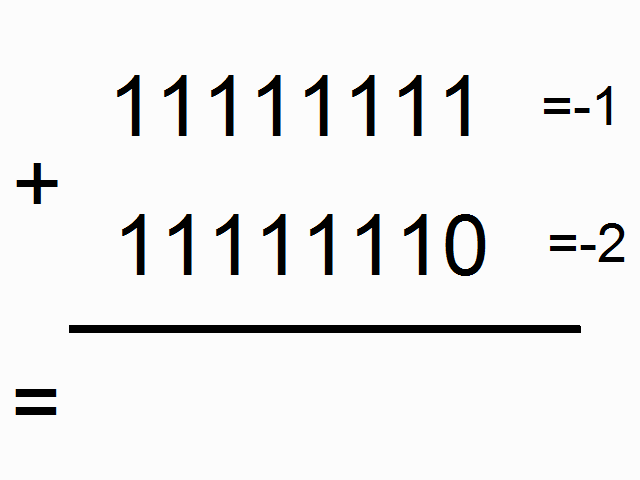

#### First we will import our libraries

In [2]:
# Import libraries
import copy, numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)
%matplotlib inline

After that we will define our activation function

In [3]:
# Utility functions
def sigmoid(x):
    output =1/(1+np.exp(-x))
    return output

def sigmoid_output_to_derivative(output):    
    return output*(1-output)

Then we will decide the binary dimension

In [4]:
# Decide the maximum binary dimension 
max_binary_dim = 8
largest_number = pow(2,max_binary_dim)
print(2**8)
print(pow(2,max_binary_dim))
print(range(2**3))

256
256
range(0, 8)


Create binary lookup table

In [6]:
# Create binary lookup table
# np.unpackbits e.g.
print(np.unpackbits(np.array([8], dtype = np.uint8)))
print("====================")

# e.g
# binary_gonna_be = np.array([range(largest_number)], dtype=np.uint8).T
# print(binary_gonna_be)


[0 0 0 0 1 0 0 0]


In [7]:
#   binary lookup table
binary = np.unpackbits(np.array([range(largest_number)], dtype=np.uint8).T, axis = 1)
print(binary.shape, binary)
print("====================")
int2binary = {}
for i in range(largest_number):
    int2binary[i] = binary[i]
print("lookup table test")
print(binary[3], int2binary[3])
#print(int2binary)

(256, 8) [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 1 0]
 ...
 [1 1 1 ... 1 0 1]
 [1 1 1 ... 1 1 0]
 [1 1 1 ... 1 1 1]]
lookup table test
[0 0 0 0 0 0 1 1] [0 0 0 0 0 0 1 1]


Initial parameter setting

In [8]:
alpha = 0.1 # learning rate
input_dim = 2 #  digit  input이 
hidden_dim = 16 # we can vary this and see what happens
output_dim = 1 # output one dim e.g. 1(2) + 1(2) = 0(2) with overflow 1

# weight initialization
synapse_0 = 2*np.random.random((input_dim,hidden_dim))-1
synapse_1 = 2*np.random.random((hidden_dim,output_dim))-1
synapse_h = 2*np.random.random((hidden_dim,hidden_dim))-1

print(synapse_0.shape, synapse_1.shape, synapse_h.shape)

(2, 16) (16, 1) (16, 16)


Saving updates

In [9]:
# saving for updates and visualization
s0_update = np.zeros(synapse_0.shape) # s0_update = np.zeros_like(synapse_0)
s1_update = np.zeros(synapse_1.shape) 
sh_update = np.zeros(synapse_h.shape) 

overallError_history = list()
accuracy = list()
accuracy_history = list()
accuracy_count = 0

Training

In [10]:
max_iter = 20000
for j in range(max_iter):
    #  binary lookup table
    # Randomly pick two integers and change it to the binary representation
    a_int = np.random.randint(1,largest_number//2)
    a = int2binary[a_int]
    b_int = np.random.randint(1,largest_number//2)
    b = int2binary[b_int]
    #
    # Calculate the answer and save it as a binary form
    c_int = a_int + b_int
    c = int2binary[c_int]
    
    # RNN이  binary 
    # Declare the variable for saving the prediction by RNN
    pred = np.zeros_like(c)
    
    overallError = 0
    
    output_layer_deltas = list()
    hidden_layer_values = list()
    hidden_layer_values.append(np.zeros(hidden_dim)) # dim: (1, 16)

    # feed forward !

    # As you have to calculate from the "first" position of the binary number, which stands for the lowest value, loop backward.
    # e.g. 
    # 10(2) + 11(2), for the first iteration: X = [[0,1]] y = [[1]]
    for position in reversed(range(max_binary_dim)):
        
        # RNN  input output label 
        # Take the input and output label binary values
        X = np.array([[a[position],b[position]]]) # dim: (1, 2), e.g. [[1,0]]
        y = np.array([[c[position]]]) # dim: (1, 1), e.g. [[1]]
        
        # hidden layer  h_t = sigmoid(X*W_{hx} + h_{t-1}*W_{hh})
        hidden_layer = sigmoid(np.dot(X,synapse_0) + np.dot(hidden_layer_values[-1],synapse_h)) # dim: (1, 16)
        
        # output_layer 
        output_layer = sigmoid(np.dot(hidden_layer,synapse_1)) # dim: (1, 1), e.g. [[0.47174173]]
        
        # error 
        output_layer_error = y-output_layer # dim: (1, 1) 
        
        # display (just for displying error curve)
        overallError += np.abs(output_layer_error[0]) # dim: (1, )          
        
        # 이  backpropagation delta 
        # Save it for the later use in backpropagation step        
        output_layer_deltas.append((output_layer_error) * sigmoid_output_to_derivative(output_layer))        
        
       
        # save the prediction by my model on this position
        pred[position] = np.round(output_layer[0][0])
        
        
        # save the hidden layer by appending the values to the list
        hidden_layer_values.append(copy.deepcopy(hidden_layer)) 
    
    if (j%100 == 0):
        overallError_history.append(overallError[0])
    
    # backpropagation !
        
    
    # As RNN needs to consider the "future" hidden layer value to calculate the backpropagation and it does not have the 
    # value at the first time (at the end of the position where backpropagation starts), we have to initialize it with zeros
    future_hidden_layer_delta = np.zeros(hidden_dim)
    
    # backpropagation
    # Now it should go "backward" which means an ordinary way in the for loop
    for position in range(max_binary_dim):
        

        # bring what you needs for calculation
        X = np.array([[a[position],b[position]]])
        hidden_layer = hidden_layer_values[-position-1]
        prev_hidden_layer = hidden_layer_values[-position-2]
        
      
        # Get the gradients flowing back from the error of my output at this position, or time step
        output_layer_delta = output_layer_deltas[-position-1]
        
        #  hidden layer gradient
        #  hidden layer error gradient +  output layer error gradient
        # sigmoid derivative 
        # 이유: h_t = sigmoid(X*W_{hx} + h_{t-1}*W_{hh})
        # Important part! (Backpropagation)
        # Think about the feed forward step you have done before: h_t = sigmoid(X*W_{hx} + h_{t-1}*W_{hh})
        hidden_layer_delta = (np.dot(future_hidden_layer_delta,synapse_h.T) + np.dot(output_layer_delta,synapse_1.T)) \
                            * sigmoid_output_to_derivative(hidden_layer)
        
        # gradient update 
        # backprop hidden layer의 value
        # Save the updates until the for loop finishes calculation for every position
        # Hidden layer values must be changed ONLY AFTER backpropagation is fully done at every position.
        s1_update += np.atleast_2d(hidden_layer).T.dot(output_layer_delta)
        sh_update += np.atleast_2d(prev_hidden_layer).T.dot(hidden_layer_delta)
        s0_update += X.T.dot(hidden_layer_delta)
        
       
        # Preparation for the next step. Now the current hidden_layer_delta becomes the future hidden_layer_delta.
        future_hidden_layer_delta = hidden_layer_delta

    # weight  update (learning rate)
    synapse_1 += s1_update*alpha
    synapse_0 += s0_update*alpha
    synapse_h += sh_update*alpha
    
    # update value initialization for the new training data ( a,b training )
    s1_update *= 0
    s0_update *= 0    
    sh_update *= 0
    
    # accuracy 
    check = np.equal(pred,c)
    if np.sum(check) == max_binary_dim:
        accuracy_count += 1
    if (j%100 == 0):
        accuracy_history.append(accuracy_count)
        accuracy_count = 0
    
    
    if (j % 100 == 0):
        print ("Error:" + str(overallError))
        print ("Pred:" + str(pred))  
        print ("True:" + str(c)) 

        final_check = np.equal(pred,c)
        print (np.sum(final_check) == max_binary_dim)

        out = 0

        for index, x in enumerate(reversed(pred)):
            out += x * pow(2, index)
        print (str(a_int) + " + " + str(b_int) + " = " + str(out))
        print ("------------")

Error:[3.97540736]
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 0 0 0 1 1 1]
False
10 + 61 = 0
------------
Error:[4.0325467]
Pred:[0 1 1 0 1 1 0 1]
True:[1 0 0 1 0 1 0 1]
False
111 + 38 = 109
------------
Error:[3.79424599]
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 1 1 1 0 0 0]
False
55 + 1 = 0
------------
Error:[3.87395152]
Pred:[0 0 0 0 0 0 0 0]
True:[0 0 0 1 1 0 0 1]
False
20 + 5 = 0
------------
Error:[4.01458433]
Pred:[1 1 1 1 1 1 1 1]
True:[0 1 0 1 0 1 1 0]
False
12 + 74 = 255
------------
Error:[3.99141219]
Pred:[0 0 0 0 0 0 0 0]
True:[0 1 1 0 0 0 1 0]
False
30 + 68 = 0
------------
Error:[3.97121353]
Pred:[0 0 0 0 1 0 0 0]
True:[0 0 1 0 0 0 0 1]
False
28 + 5 = 8
------------
Error:[4.02250446]
Pred:[1 1 1 1 1 1 1 0]
True:[0 1 0 1 1 0 1 1]
False
60 + 31 = 254
------------
Error:[4.04634296]
Pred:[1 1 0 1 0 1 0 1]
True:[0 1 1 1 1 1 1 1]
False
23 + 104 = 213
------------
Error:[3.87790083]
Pred:[1 0 1 1 1 1 1 0]
True:[1 1 0 1 0 1 1 0]
False
124 + 90 = 190
------------
Error:[3.8993887]
Pred:[0 0 0 0

Error:[0.45513889]
Pred:[0 1 0 1 0 0 1 1]
True:[0 1 0 1 0 0 1 1]
True
70 + 13 = 83
------------
Error:[0.27921542]
Pred:[0 1 0 1 1 0 1 1]
True:[0 1 0 1 1 0 1 1]
True
90 + 1 = 91
------------
Error:[0.62198489]
Pred:[1 1 1 1 0 1 0 1]
True:[1 1 1 1 0 1 0 1]
True
127 + 118 = 245
------------
Error:[0.50229076]
Pred:[1 0 0 1 0 1 0 1]
True:[1 0 0 1 0 1 0 1]
True
57 + 92 = 149
------------
Error:[0.58217015]
Pred:[0 1 1 1 0 0 0 0]
True:[0 1 1 1 0 0 0 0]
True
21 + 91 = 112
------------
Error:[0.50710971]
Pred:[1 0 1 1 1 0 1 0]
True:[1 0 1 1 1 0 1 0]
True
115 + 71 = 186
------------
Error:[0.51719454]
Pred:[0 1 1 1 0 0 0 1]
True:[0 1 1 1 0 0 0 1]
True
18 + 95 = 113
------------
Error:[0.47046102]
Pred:[1 1 1 0 1 1 1 0]
True:[1 1 1 0 1 1 1 0]
True
116 + 122 = 238
------------
Error:[0.51538252]
Pred:[0 1 0 1 0 0 0 1]
True:[0 1 0 1 0 0 0 1]
True
47 + 34 = 81
------------
Error:[0.48485176]
Pred:[1 0 1 1 0 0 0 1]
True:[1 0 1 1 0 0 0 1]
True
73 + 104 = 177
------------
Error:[0.45145853]
Pred:[1 0

Error:[0.23058793]
Pred:[1 0 1 0 1 0 1 0]
True:[1 0 1 0 1 0 1 0]
True
88 + 82 = 170
------------
Error:[0.30600955]
Pred:[1 0 0 0 0 0 0 1]
True:[1 0 0 0 0 0 0 1]
True
99 + 30 = 129
------------
Error:[0.24408132]
Pred:[0 1 0 1 1 0 0 0]
True:[0 1 0 1 1 0 0 0]
True
52 + 36 = 88
------------
Error:[0.26199122]
Pred:[1 0 0 1 1 0 1 0]
True:[1 0 0 1 1 0 1 0]
True
127 + 27 = 154
------------
Error:[0.2308597]
Pred:[1 1 0 1 1 1 0 0]
True:[1 1 0 1 1 1 0 0]
True
106 + 114 = 220
------------
Error:[0.26871153]
Pred:[1 0 0 0 1 0 0 0]
True:[1 0 0 0 1 0 0 0]
True
21 + 115 = 136
------------
Error:[0.14836389]
Pred:[0 1 1 1 0 1 1 1]
True:[0 1 1 1 0 1 1 1]
True
99 + 20 = 119
------------
Error:[0.26056678]
Pred:[1 1 1 1 0 1 1 1]
True:[1 1 1 1 0 1 1 1]
True
126 + 121 = 247
------------
Error:[0.21699123]
Pred:[0 1 0 0 0 1 1 1]
True:[0 1 0 0 0 1 1 1]
True
52 + 19 = 71
------------
Error:[0.15114712]
Pred:[0 1 1 1 0 0 1 1]
True:[0 1 1 1 0 0 1 1]
True
51 + 64 = 115
------------
Error:[0.23657825]
Pred:[1 

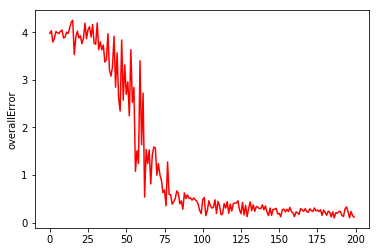

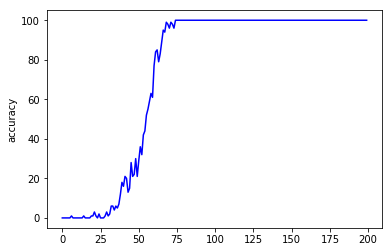

In [11]:
#print(overallError_history)
x_range = range(max_iter//100)
plt.plot(x_range,overallError_history,'r-')
plt.ylabel('overallError')
plt.show()

plt.plot(x_range,accuracy_history,'b-')
plt.ylabel('accuracy')
plt.show()